# Śledzenie rozgyrwki bilarda

## Import niezbędnych bibliotek

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import deque
# import PIL
# import os
# import sys
# import glob
# import random

# from pprint import pprint
from ipywidgets import Video

import PIL
from IPython.display import display
# from PIL.ExifTags import TAGS

def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

## Analiza wideo

### Wczytanie wideo i jego podstawowych właściwości

In [13]:
video = cv2.VideoCapture('data/9-ball/video6.mov')
if video.isOpened():
    print('Movie loaded :)')

width = int(video.get(3))
height = int(video.get(4))
print(f'Wysokość i szerokość obrazu: {height} x {width}')

fps = video.get(cv2.CAP_PROP_FPS)
print(f'Liczba klatek na sekundę: {fps}')

Movie loaded :)
Wysokość i szerokość obrazu: 1054 x 1924
Liczba klatek na sekundę: 59.891696750902526


### Wyświetlenie analizowanego wideo

In [14]:
Video.from_file('data/9-ball/video11.mov')

Video(value=b'\x00\x00\x00\x14ftypqt  \x00\x00\x00\x00qt  \x00\x00\x00\x08wide\x00D\xd0mmdat\x00\x00\x00\x1e\x…

### Oddzielenie tła od ruszających się obiektów

In [15]:
video_foreground_knn = cv2.VideoWriter('foreground_knn.avi', cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height), 0)
video_foreground_mog2 = cv2.VideoWriter('foreground_mog2.avi', cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height), 0)

foreground_knn = cv2.createBackgroundSubtractorKNN()
foreground_mog2 = cv2.createBackgroundSubtractorMOG2()

video.set(cv2.CAP_PROP_POS_FRAMES, 0)
while video.isOpened():
  ret, frame = video.read()

  if ret:
    video_foreground_knn.write(foreground_knn.apply(frame))
    video_foreground_mog2.write(foreground_mog2.apply(frame))
  else:
    break

video_foreground_knn.release()
video_foreground_mog2.release()

KeyboardInterrupt: 

### Konwersja formatów wygenerowanych wideo

In [ ]:
!ffmpeg -hide_banner -loglevel error -i foreground_knn.avi -y foreground_knn.mp4
!ffmpeg -hide_banner -loglevel error -i foreground_mog2.avi -y foreground_mog2.mp4

### Wyświetlenie wyników działania algorytmów oddzielających tło od ruszających się obiektów (maskujących tło)

In [ ]:
print('Algorytm cv2.createBackgroundSubtractorKNN()')
Video.from_file('foreground_knn.mp4')

Algorytm cv2.createBackgroundSubtractorKNN()


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0b Smdat\x00\x00\…

In [ ]:
print('Algorytm cv2.createBackgroundSubtractorMOG2()')
Video.from_file('foreground_mog2.mp4')

Algorytm cv2.createBackgroundSubtractorMOG2()


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0f\x17\x9dmdat\x0…

Po analizie wyników działania powyższych algorytmów do dalszej pracy wybieram algorytm KNN, który osiągnął lepszy wynik od MOG2.

### Poszukiwanie współrzędnych bil na filmie

In [189]:
import time as time
video = cv2.VideoCapture('data/9-ball/video7.mov')
circles = None


while True:
    # Take each frame
    _, frame = video.read()

    # If video ends then break
    if frame is None:
        break

    blur = cv2.medianBlur(frame,5)
    cimg = cv2.cvtColor(blur,cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(cimg,cv2.HOUGH_GRADIENT,1,20,
                            param1=60,param2=20,minRadius=13,maxRadius=22)

    circles = np.uint16(np.around(circles))

    

    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(frame,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(frame,(i[0],i[1]),2,(0,0,255),3)

    cv2.imshow('frame',frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

### Wykorzystanie algorytmu CSRT do śledzenia znalezionych bili na filmie

In [3]:
def create_tracker(tracker_type):
  tracker_types = ['BOOSTING', 'MIL','KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']

  if tracker_type == 'BOOSTING':
      return cv2.legacy.TrackerBoosting_create()
  if tracker_type == 'MIL':
      return cv2.legacy.TrackerMIL_create()
  if tracker_type == 'KCF':
      return cv2.legacy.TrackerKCF_create()
  if tracker_type == 'TLD':
      return cv2.legacy.TrackerTLD_create()
  if tracker_type == 'MEDIANFLOW':
      return cv2.legacy.TrackerMedianFlow_create()
  if tracker_type == 'GOTURN':
      return cv2.TrackerGOTURN_create()
  if tracker_type == 'MOSSE':
      return cv2.legacy.TrackerMOSSE_create()
  if tracker_type == "CSRT":
      return cv2.TrackerCSRT_create()

def draw_bbox(frame, bbox, color=(255, 255, 255)):
  p1 = (int(bbox[0]), int(bbox[1]))
  p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
  cv2.rectangle(frame, p1, p2, color, 2, 1)

def circle_to_rectangle(circle):
    return (int(circle[0]-circle[2]-5), int(circle[1]-circle[2]-5), int(2*circle[2]+10),  int(2*circle[2]+10))

Movie loaded :)
Wysokość i szerokość obrazu: 1172 x 2144
Liczba klatek na sekundę: 59.21052631578947


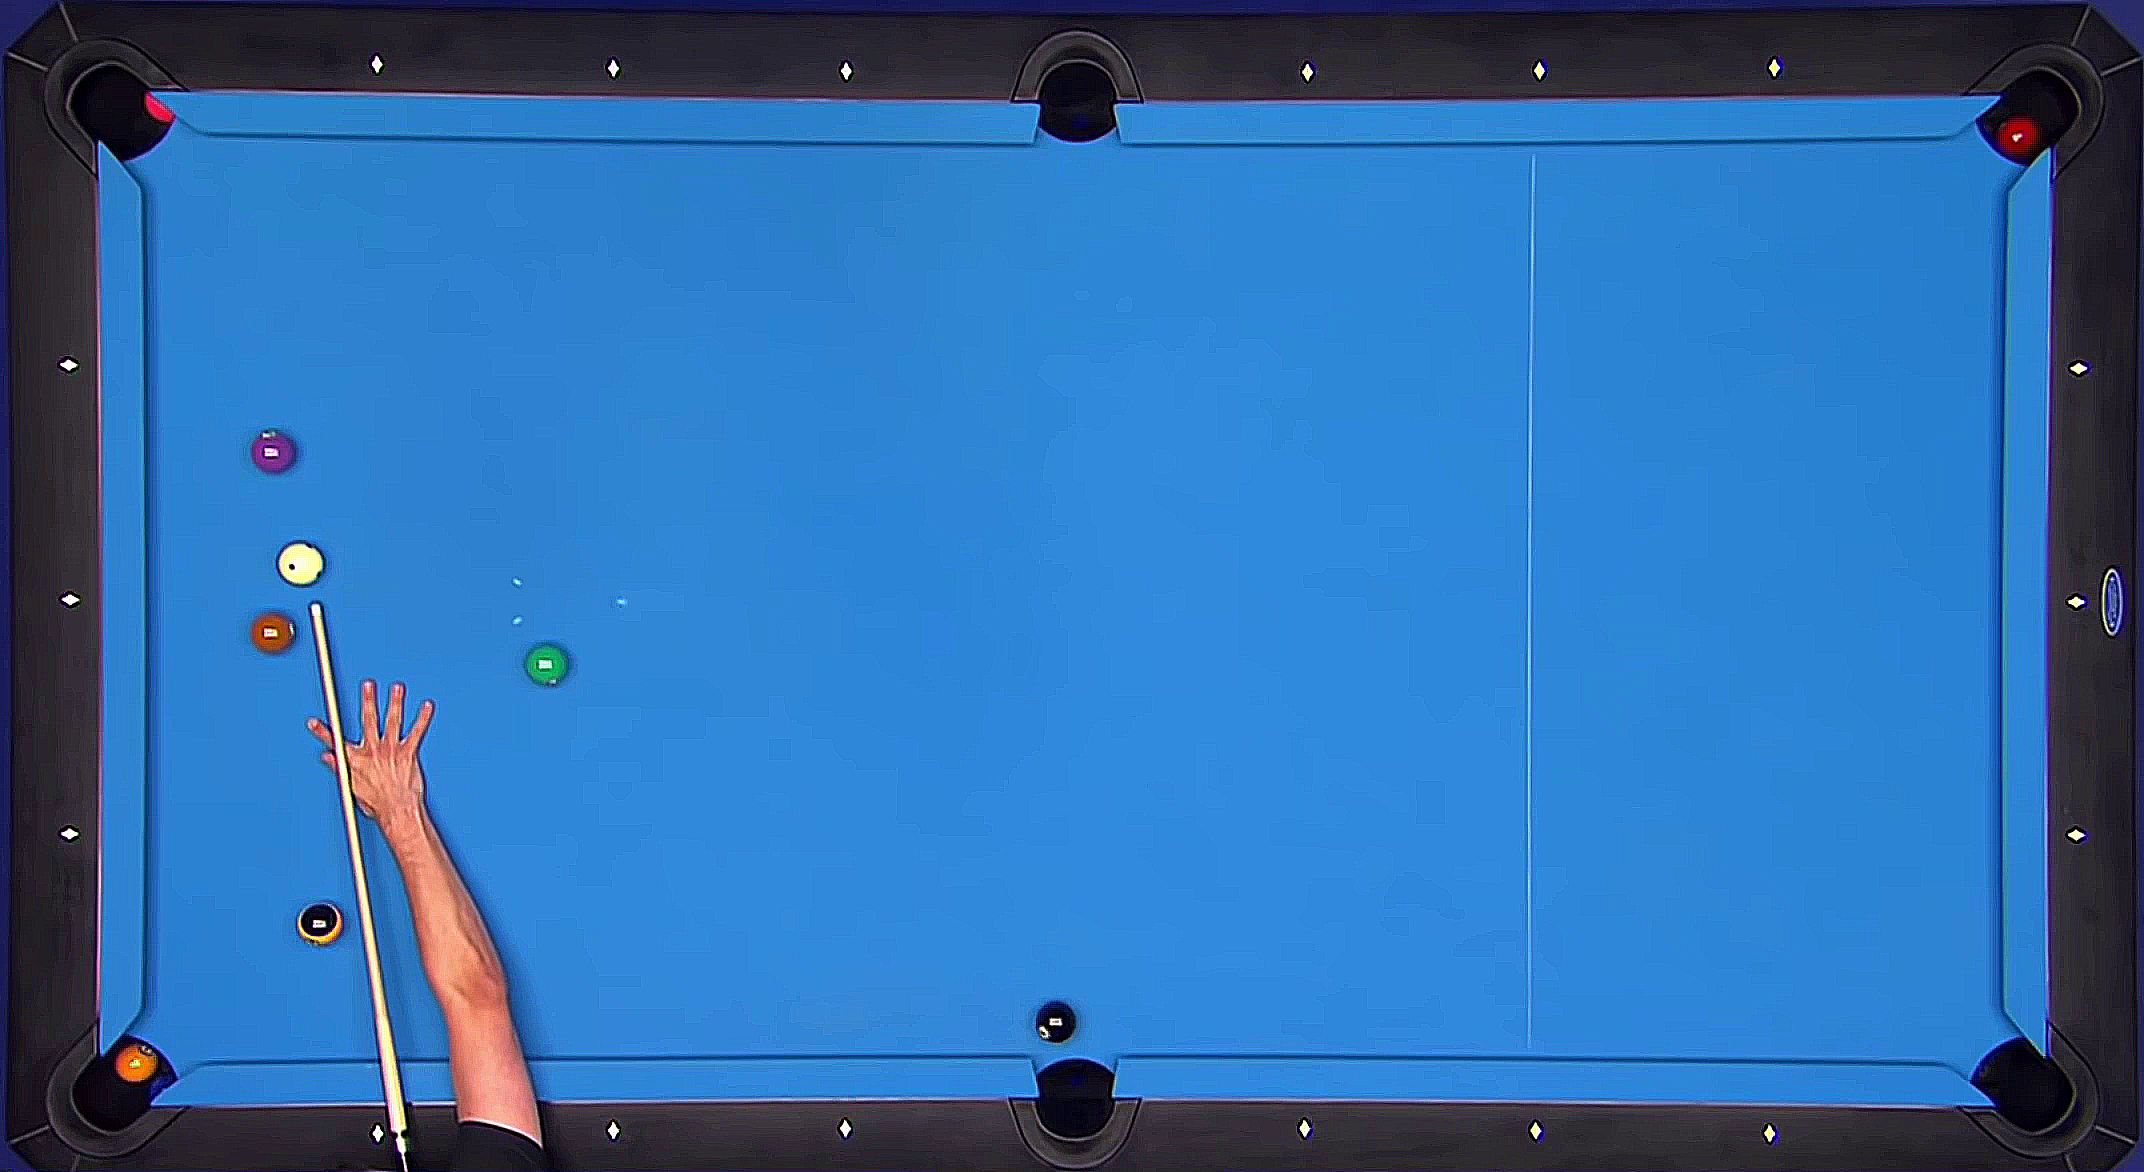

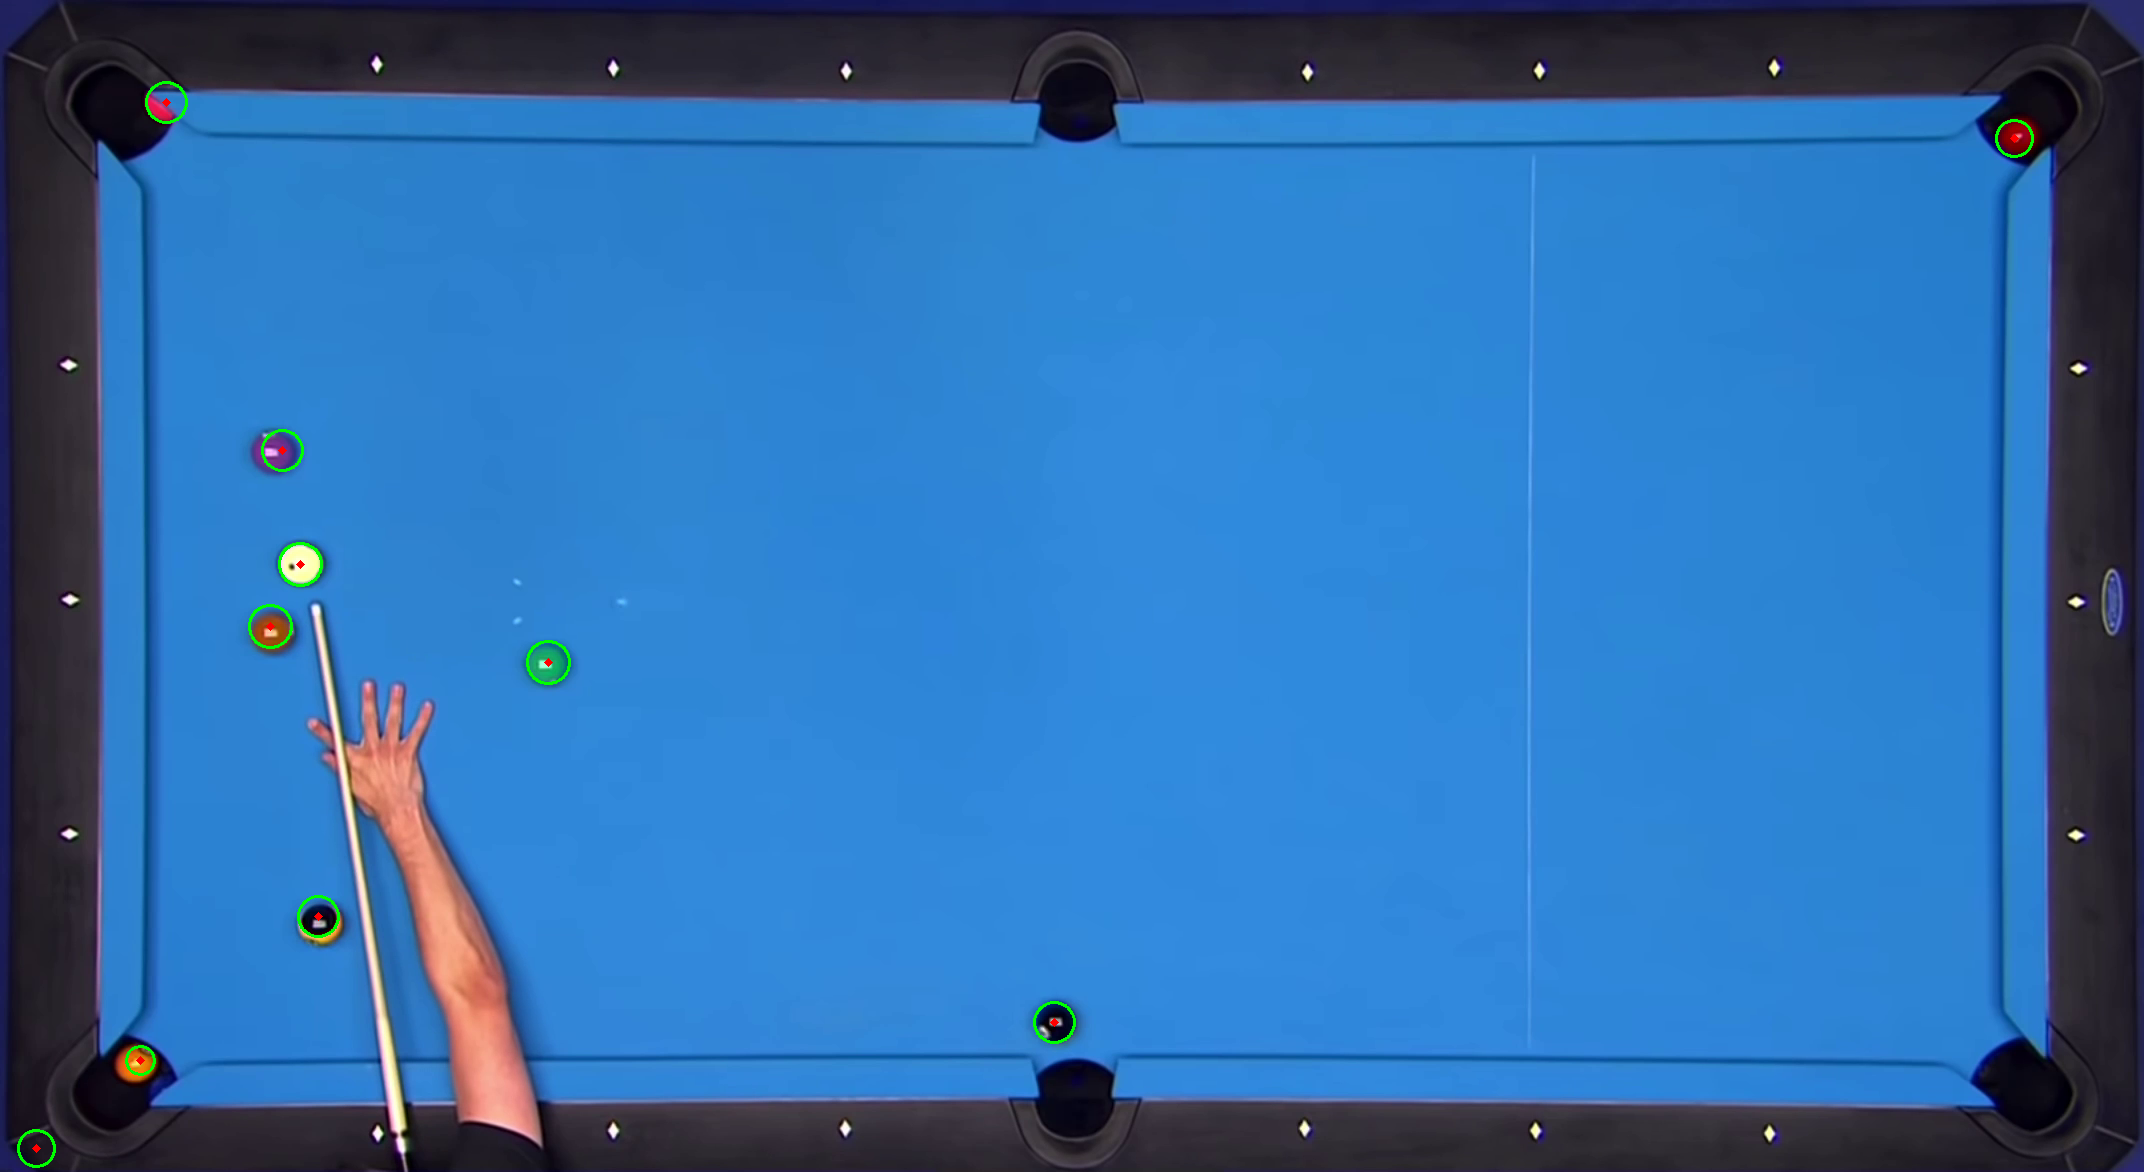

In [204]:
video = cv2.VideoCapture('data/9-ball/video1.mov')
if video.isOpened():
    print('Movie loaded :)')

width = int(video.get(3))
height = int(video.get(4))
print(f'Wysokość i szerokość obrazu: {height} x {width}')

fps = video.get(cv2.CAP_PROP_FPS)
print(f'Liczba klatek na sekundę: {fps}')

video.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = video.read()

# color = ('b','g','r')
# for i,col in enumerate(color):
#     histr = cv2.calcHist([frame],[i],None,[256],[0,256])
#     plt.plot(histr,color = col)
#     plt.xlim([0,256])
# plt.show()

# histr = cv2.calcHist([frame],[0],None,[256],[0,256])
# plt.plot(histr)
# plt.show()
# print(np.argmax(histr))



filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpen_img_1=cv2.filter2D(frame,-1,filter)
imshow(sharpen_img_1)

cimg = cv2.cvtColor(sharpen_img_1,cv2.COLOR_BGR2GRAY)

circles = cv2.HoughCircles(cimg,cv2.HOUGH_GRADIENT,1,20,
                            param1=60,param2=20,minRadius=13,maxRadius=22)
circles = np.uint16(np.around(circles))

bills = []
count = 0
for c in circles[0]:
  bills.append(create_tracker('CSRT'))
  bills[-1].init(frame, circle_to_rectangle(c))
  count += 1

# print(count)

for i in circles[0,:]:
  # draw the outer circle
  cv2.circle(frame,(i[0],i[1]),i[2],(0,255,0),2)
  # draw the center of the circle
  cv2.circle(frame,(i[0],i[1]),2,(0,0,255),3)

imshow(frame)


video_tracker = cv2.VideoWriter('video_tracker.avi', cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))

video.set(cv2.CAP_PROP_POS_FRAMES, 0)
while video.isOpened():
    ret, frame = video.read()

    if ret:
      for b in bills:
        ok, bbox = b.update(frame)
        if ok: draw_bbox(frame, bbox, (0, 255, 0))

      video_tracker.write(frame)
    else:
        break

video_tracker.release()

In [205]:
!ffmpeg -hide_banner -loglevel error -i video_tracker.avi -y video_tracker.mp4

In [206]:
Video.from_file('./video_tracker.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\'\x1e*mdat\x00\x00…